## Imports

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.metrics import ConfusionMatrixDisplay


# Reproduserbarhet
np.random.seed(5)

## Dataset og datasettbehandling

Shape X: (13067, 400)
Shape y: (13067,)
Antall klasser: 15


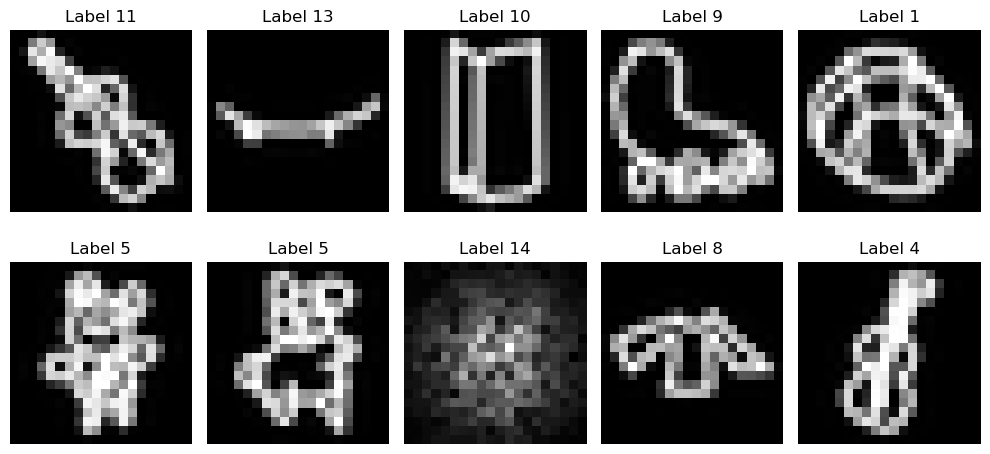

In [9]:
dataset = np.load("dataset.npz")
X, y = dataset["X"], dataset["y"]

print("Shape X:", X.shape)
print("Shape y:", y.shape)
print("Antall klasser:", len(np.unique(y)))

# Se noen eksempler
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[i].reshape(20, 20), cmap="gray")
    ax.set_title(f"Label {y[i]}")
    ax.axis("off")
plt.tight_layout()
plt.show()


## Pre processing

In [10]:
X = X / 255.0

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=5
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (10453, 400)
Test size: (2614, 400)


## Modelvalg og hyperparameter tuning

In [11]:
rf_param_grid = {
    "n_estimators": [80, 120],          # Dropp 150 (liten gevinst, stor kostnad)
    "max_depth": [None, 15],            # 10 og 20 kan byttes med 15 som midtpunkt
    "min_samples_split": [2, 5],        # Vanligvis nok variasjon
    "min_samples_leaf": [1, 2],         # Dekker de vanligste
    "max_features": ["sqrt"],           # Mest brukt og ofte best for bilder
    "bootstrap": [True]                 # Bootstrap = standard
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=5, n_jobs=-1),
    rf_param_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)

print("Best RF Parameters:", rf_grid.best_params_)
print("Best RF CV Score:", rf_grid.best_score_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best RF Parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 120}
Best RF CV Score: 0.7381616912677534


In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_param_grid = {
    "n_neighbors": [3, 5, 7, 9],         # De mest relevante verdiene
    "weights": ["uniform", "distance"],  # Fortsatt begge
    "p": [1, 2],                            # Bruk kun Euclidean-avstand (standard)
    "algorithm": ["auto"],               # La KNN velge raskeste implementasjon
    "leaf_size": [30]                    # Standardverdi, sjelden avgjørende
}

knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    knn_param_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

knn_grid.fit(X_train, y_train)

print("Best KNN Parameters:", knn_grid.best_params_)
print("Best KNN CV Score:", knn_grid.best_score_)


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best KNN Parameters: {'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
Best KNN CV Score: 0.7439973183415226


## Evaluering av metoder


Random Forest
Accuracy: 0.7502
              precision    recall  f1-score   support

           0      0.767     0.817     0.791       109
           1      0.540     0.744     0.626       180
           2      0.852     0.820     0.835       161
           3      0.800     0.176     0.288        91
           4      0.704     0.642     0.672       204
           5      0.720     0.864     0.785       273
           6      0.743     0.826     0.782       172
           7      0.632     0.216     0.322       111
           8      0.819     0.837     0.828       178
           9      0.771     0.808     0.789       167
          10      0.760     0.750     0.755       156
          11      0.730     0.759     0.744       320
          12      0.689     0.586     0.633       140
          13      0.804     0.881     0.841       177
          14      1.000     1.000     1.000       175

    accuracy                          0.750      2614
   macro avg      0.755     0.715     0.713     

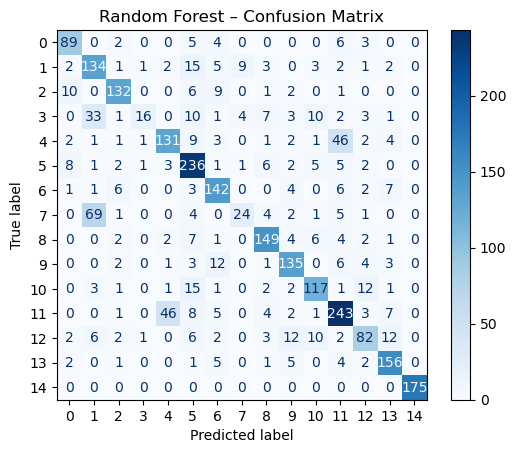


KNN
Accuracy: 0.7571
              precision    recall  f1-score   support

           0      0.667     0.899     0.766       109
           1      0.576     0.694     0.630       180
           2      0.778     0.870     0.821       161
           3      0.556     0.330     0.414        91
           4      0.619     0.652     0.635       204
           5      0.932     0.758     0.836       273
           6      0.866     0.750     0.804       172
           7      0.565     0.315     0.405       111
           8      0.840     0.882     0.860       178
           9      0.829     0.844     0.837       167
          10      0.759     0.769     0.764       156
          11      0.721     0.759     0.740       320
          12      0.721     0.571     0.637       140
          13      0.722     0.938     0.816       177
          14      1.000     1.000     1.000       175

    accuracy                          0.757      2614
   macro avg      0.743     0.736     0.731      2614
weig

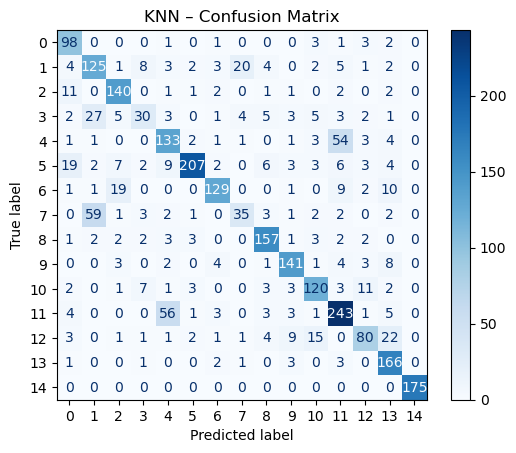

In [17]:
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

best_rf = rf_grid.best_estimator_
best_knn = knn_grid.best_estimator_

for name, model in [("Random Forest", best_rf), ("KNN", best_knn)]:
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)

    print(f"\n{name}")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, preds, digits=3, zero_division=0))

    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap="Blues")
    plt.title(f"{name} – Confusion Matrix")
    plt.show()
